In [1534]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import re

from nltk.tokenize import word_tokenize

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


nltk.download('stopwords')
nltk.download('punkt')

STOPWORDS = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /home/tales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tales/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1535]:
DATASET = 'fakeWhatsApp.BR_2020_partial.csv'

In [1536]:
df = pd.read_csv(os.path.join('data', '2020', DATASET))

In [1537]:
df.shape, df.columns

((2899, 5),
 Index(['shares', 'text', 'misinformation', 'source', 'revision'], dtype='object'))

In [1538]:
df.head()

shares  \
0      27   
1      26   
2      25   
3      25   
4      24   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text  \
0                           O ministro da Ciência, Tecnologia, Inovações e Comunicações, Marcos Pontes, afirmou, nesta terça-feira (9), que foram iniciados os novos testes com o vermífugo nitazoxanida em pacientes que tenham sido infectados pelo novo coronavírus. A novidade é que a partir de agora pacientes assintomáticos também serão testados. Basta ter a confirmação do coronavírus. O primeiro protocolo de testes trabalha com pessoas com febre e início de pneumonia, com o chamado “vidro fosco” na tomografia do pulmão.\r\nhttps://dunapress.org/2020/06/11/governo-jair-bolsonaro-atraves-do-mctic-inicia-segundo-protocolo-de-testes-clinicos-com-a-nitazoxanida/   
1                                                                                                                                                                                                                                                                                                                                                                                        Pesquisa com mais de 6.000 médicos em 30 países diz que hidroxicloroquina é o tratamento mais eficaz para coronavírus.\r\n\r\nhttps://conexaopolitica.com.br/ultimas/pesquisa-com-mais-de-6-000-medicos-em-30-paises-diz-que-hidroxicloroquina-e-o-tratamento-mais-eficaz-para-coronavirus/amp/   
2  É com muita alegria que comunico que mais um pedido nosso relacionado ao Coronavírus foi atendido! O Ministério da Educação decidiu adiantar a formatura dos estudantes de Medicina, Enfermagem e outros cursos da área da Saúde para atuarem nos hospitais no enfrentamento da Covid-19! São mais de 10 mil universitários jovens e corajosos que com certeza querem se juntar às equipes médicas que atuam na linha de frente do combate ao Coronavírus!\r\n.\r\nObrigado, MEC! E eu continuo em contato com reitores de universidades e faculdades para conseguir mais apoio para essa importante iniciativa!\r\n\r\nhttps://www.instagram.com/p/B-pnWueIqL2/?igshid=1je4qpnb5hczy   
3                                                                                                                                                                                 Renda Brasil unificará vários programas sociais. O ministro da Economia, Paulo Guedes, anunciou que o governo federal criará um programa de renda mínima permanente, após a pandemia do novo coronavírus (covid-19), batizado de Renda Brasil. O ministro disse ainda que será criado um programa para geração de empregos formais, com a retomada do projeto Carteira Verde e Amarela. ...\r\nhttps://dunapress.org/2020/06/09/governo-vai-criar-programa-de-renda-minima-apos-a-pandemia-diz-guedes/   
4                                                                                                                                                                                                                                                                                                   O Secretário-Geral da OTAN Jens Stoltenberg também ex Primeiro Ministro da Noruega 2000-2013 em seu pronunciamento sobre o lançamento do programa #NATO2030 - Fortalecendo a Aliança em um mundo cada vez mais competitivo deixa a seguinte mensagem: "A aliança precisa e deve enfrentar a China!",

<AxesSubplot:>

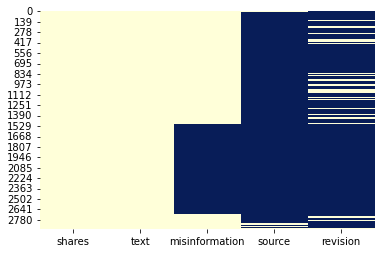

In [1539]:
# Visualização geral de dados faltantes
sns.heatmap(df.isna(), cmap='YlGnBu', cbar=False)

In [1540]:
# Comparando quantos dados faltantes existem no atributo text
print(df['text'].notnull().sum(), df.shape[0])

df = df[df['text'].notnull()]

2898 2899


## Distribuição das classes

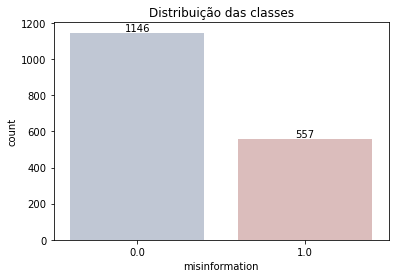

In [1541]:
plt.hist(df['misinformation'])
plt.title("Distribuição das classes")
ax = sns.countplot(x='misinformation', data=df, palette='vlag')
ax.bar_label(ax.containers[1])
plt.show()

In [1542]:
df.iloc[847]

shares                                                                                                                                                                                                 1
text              Enquanto aqui no Amapá  as outras doenças e  quem é curado de coronaviros não tem nem uma importância a maior importância neste momento é falir o estado pra culpar o governo federal.
misinformation                                                                                                                                                                                       1.0
source                                                                                                                                                                                               NaN
revision                                                                                                                                                                                            

In [1543]:
# Usando apenas os dados que contem 'misinformation'
df = df[df['misinformation'].notnull()]

## Criando features a partir do texto

In [1544]:
def count_chars(text):
    """Counts the number of characters in a message."""
    return len(text)

def count_words(text):
    """Counts the number of words in a message."""
    return len(text.split())

def count_capital_chars(text):
    """Counts the number of capital characters in a message."""
    counter = 0
    for word in text:
        if word.isupper():
            counter += 1
    return counter

def count_capital_words(text):
    """Counts the number of capital words in a message."""
    return sum(map(str.isupper, text.split()))

def count_punctuations(text):
    """Return a dictionary of 32 punctuation counts."""
    punctuations="""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
    
    punctuactions_countings = dict()
    
    for punct in punctuations:
        punctuactions_countings[str(punct) + ' count'] = text.count(punct)
        
    return punctuactions_countings

def count_words_in_quotes(text):
    """Counts the number of words in both single and double quotation."""
    x = re.findall("""'.'|".""""", text)
    
    counter = 0
    
    if x is None:
        return 0
    else:
        for index in x:
            t = index[1:-1]
            counter += count_words(t)
        return counter

def count_sent(text):
    """Counts the number of sentences in a message."""
    return len(nltk.sent_tokenize(text))

def count_unique_words(text):
    """Counts the number of unique words in a message."""
    return len(set(text.split()))

def count_htags(text):
    """Counts the number of hashtags in a text."""
    htags_w = re.findall(r'\B(\#[a-zA-Z]+\b)(?!;)', text)
    return len(htags_w)

def count_mentions(text):
    """Counts the amount of times users have been mentioned."""
    mentions_w = re.findall(r'\B@\w+', text)
    return len(mentions_w)

def count_stopwords(text):
    """Count the number of stopwords in a message."""
    stop_words = set(STOPWORDS)
    word_tokens = word_tokenize(text)
    stopwords_x = [word for word in word_tokens if word in stop_words]
    return len(stopwords_x)

def count_links(text):
    """Counts the number of links present in a message."""
    pattern = r"(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
    return len(re.findall(pattern, text))

def remove_links(text):
    pttrn = r"(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])"
    return re.sub(pttrn, " ", text)

def remove_whitespaces(text):
    return text.strip()

def set_lowercase(text):
    return text.lower()

def check_lol(text):
    PATTERN_1 = r"(k|K){2,}"
    # PATTERN_2 = r"((h|H)(a|A)){2,}"
    return bool(re.search(pattern=PATTERN_1, string=text))

def clean_lol(text):
    PATTERN_1 = r"(k|K){2,}"
    return re.sub(pattern=PATTERN_1, repl="", string=txt)

### Aplicando as transformações para criação das features

In [1545]:
df['char_count']         = df["text"].apply(lambda msg: count_chars(msg))
df['word_count']         = df["text"].apply(lambda msg: count_words(msg))
df['sent_count']         = df["text"].apply(lambda msg: count_sent(msg))
df['capital_char_count'] = df["text"].apply(lambda msg: count_capital_chars(msg))
df['capital_word_count'] = df["text"].apply(lambda msg: count_capital_words(msg))
df['quoted_word_count']  = df["text"].apply(lambda msg: count_words_in_quotes(msg))
df['stopword_count']     = df["text"].apply(lambda msg: count_stopwords(msg))
df['unique_word_count']  = df["text"].apply(lambda msg: count_unique_words(msg))
df['htag_count']         = df["text"].apply(lambda msg: count_htags(msg))
df['mention_count']      = df["text"].apply(lambda msg: count_mentions(msg))
df['punct_count']        = df["text"].apply(lambda msg: count_punctuations(msg))
df['avg_wordlength']     = df['char_count'] / df['word_count']
df['avg_sentlength']     = df['word_count'] / df['sent_count']
df['unique_vs_words']    = df['unique_word_count'] / df['word_count']
df['stopwords_vs_words'] = df['stopword_count'] / df['word_count']
df['links_count']        = df["text"].apply(lambda msg: count_links(msg))
df['clean_text']         = df["text"].apply(lambda msg: remove_links(msg))
df['clean_text']         = df["clean_text"].apply(lambda msg: remove_whitespaces(msg))
df['has_lol']            = df["text"].apply(lambda msg: check_lol(msg))
df['clean_text']         = df["clean_text"].apply(lambda msg: set_lowercase(msg))

In [1546]:
df.reset_index(inplace=True, drop=True)

In [1547]:
df.head(2)

shares  \
0      27   
1      26   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  \
0  O ministro da Ciência, Tecnologia, Inovações e Comunicações, Marcos Pontes, afirmou, nesta terça-feira (9), que foram iniciados os novos testes com o vermífugo nitazoxanida em pacientes que tenham sido infectados pelo novo coronavírus. A novidade é que a partir de agora pacientes assintomáticos também serão testados. Basta ter a confirmação do coronavírus. O primeiro protocolo de testes trabalha com pessoas com febre e início de pneumonia, com o chamado “vidro fosco” na tomografia do pulmão.\r\nhttps://dunapress.org/2020/06/11/governo-jair-bolsonaro-atraves-do-mctic-inicia-segundo-protocolo-de-testes-clinicos-com-a-nitazoxanida/   
1                                                                                                                                                                                                                                                                                                                                                               Pesquisa com mais de 6.000 médicos em 30 países diz que hidroxicloroquina é o tratamento mais eficaz para coronavírus.\r\n\r\nhttps://conexaopolitica.com.br/ultimas/pesquisa-com-mais-de-6-000-medicos-em-30-paises-diz-que-hidroxicloroquina-e-o-tratamento-mais-eficaz-para-coronavirus/amp/   

   misinformation  \
0             0.0   
1             1.0   

                                                                                                                               source  \
0  https://www.gov.br/pt-br/noticias/educacao-e-pesquisa/2020/06/mctic-inicia-segundo-protocolo-de-testes-clinicos-com-a-nitazoxanida   
1  https://www.aosfatos.org/noticias/e-falso-que-pesquisa-indica-tratamento-com-hidroxicloroquina-como-o-mais-eficaz-contra-covid-19/   

   revision  char_count  word_count  sent_count  capital_char_count  \
0       NaN         634          76           5                  10   
1       NaN         283          20           2                   1   

   capital_word_count  quoted_word_count  stopword_count  unique_word_count  \
0                   3                  0              28                 61   
1                   0                  0               9                 19   

   htag_count  mention_count  \
0           0              0   
1           0              0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                         punct_count  \
0  {'! count': 0, '" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 1, ') count': 1, '* count': 0, '+ count': 0, ', count': 7, '- count': 15, '. count': 5, '/ count': 7, ': count': 1, '; count': 0, '< count': 0, '= count': 0, '> count': 0, '? count': 0, '@ count': 0, '[ count': 0, '\ count': 0, '] count': 0, '^ count': 0, '_ count': 0, '` count': 0, '{ count': 0, '| count': 0, '} count': 0, '~ count': 0}   
1  {'! count': 0, '" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count

## Visualizando frequência das palavras

In [1548]:
from wordcloud import WordCloud

In [1549]:
# text = " ".join(df['clean_text'])
text_misinfo = " ".join(df[df['misinformation'] == 1]['clean_text'])
text_info = " ".join(df[df['misinformation'] == 0]['clean_text'])

(-0.5, 749.5, 499.5, -0.5)

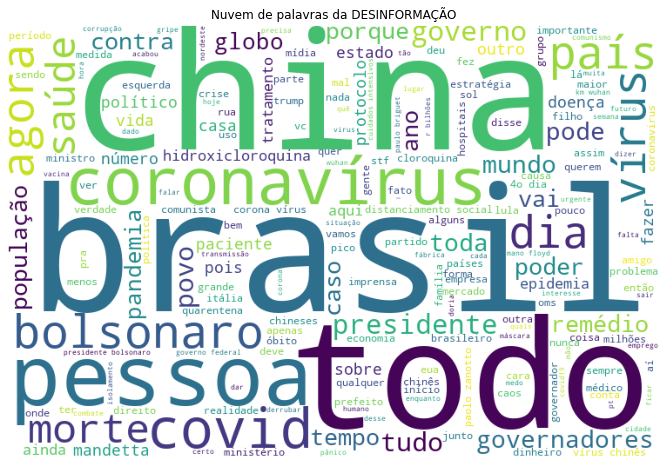

In [1550]:
wc = WordCloud(stopwords=STOPWORDS, background_color='white', width=750, height=500).generate(text_misinfo)

plt.figure(figsize=(18, 8))
plt.title("Nuvem de palavras da DESINFORMAÇÃO")
plt.imshow(wc)
plt.axis("off")

(-0.5, 749.5, 499.5, -0.5)

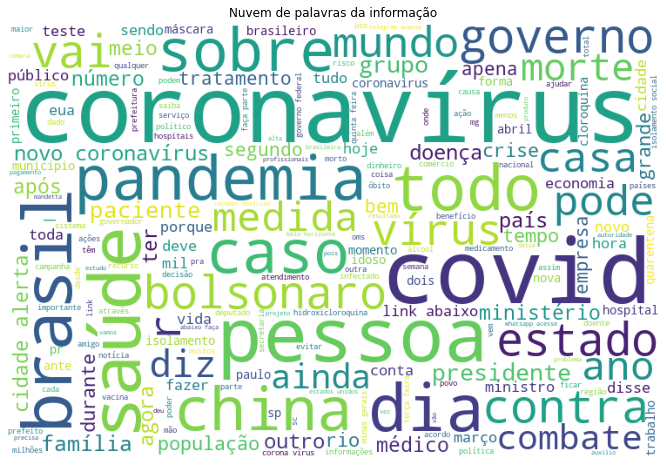

In [1551]:
wc = WordCloud(stopwords=STOPWORDS, background_color='white', width=750, height=500).generate(text_info)

plt.figure(figsize=(18, 8))
plt.title("Nuvem de palavras da informação")
plt.imshow(wc)
plt.axis("off")

In [1552]:
# df['clean_text'].shape

In [1553]:
# tfidf_matrix

## Aplicando o modelo

### Vetorização

In [1554]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [1555]:
# Criar instância da classe tfidf
tfidf = TfidfVectorizer(stop_words=STOPWORDS)

In [1556]:
# Construir a matrix TF-IDF ajustando e transformando os dados
tfidf_matrix = tfidf.fit_transform(df['clean_text'])

In [1557]:
tfidf_matrix.shape

(1703, 16812)

### Calculando simularidade via cosseno

In [1558]:
from sklearn.metrics.pairwise import linear_kernel

In [1559]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [1560]:
cosine_sim.shape

(1703, 1703)

In [1561]:
# Definição de funções auxiliares
NUM_LINES = 110

def get_recommendations(df, index, cosine_sim, t_rec=5):
    idxs = pd.Series(df.index)
    
    try:
        idx = idxs.iloc[index]
    except KeyError:
        print('Index not found!')
        return None
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(t_rec+1)]
    # msg_indices = [score[0] for score in sim_scores]
    return sim_scores


def show_recommendations(df, recs):
    
    recs = pd.DataFrame(recs, columns=['index', 'similarity_score'])
    recs['text'] = df.iloc[recs.iloc[:, 0]]['text'].to_list()
    recs = recs.set_index('index')

    for idx, (sim_score, text) in recs.iterrows():
        print(NUM_LINES * "-")
        print(f"Índice {idx} | Similaridade {np.round(sim_score, 3)}\n")
        # print(sim_score)
        print(text)
        print("\n")
    
    print(NUM_LINES * "-")

In [1562]:
MSG_INDEX = 4

print(df.iloc[MSG_INDEX]['text'])
print(df.iloc[MSG_INDEX]['misinformation'])

O Secretário-Geral da OTAN Jens Stoltenberg também ex Primeiro Ministro da Noruega 2000-2013 em seu pronunciamento sobre o lançamento do programa #NATO2030 - Fortalecendo a Aliança em um mundo cada vez mais competitivo deixa a seguinte mensagem: "A aliança precisa e deve enfrentar a China!", OTAN Vídeo: Hoje no mundo Militar...
https://dunapress.org/2020/06/11/50619/
0.0


### Gerando as cinco mensagens mais similares à mensagem de índice `MSG_INDEX`

In [1563]:
recommendations = get_recommendations(df, MSG_INDEX, cosine_sim)

show_recommendations(df, recommendations) 

--------------------------------------------------------------------------------------------------------------
Índice 1396 | Similaridade 0.11

Parece que o embaixador da China é o GOVERNADOR GERAL da colônia Brasil, e Maia seu primeiro ministro. Bolsonaro parece que ficou pra decoração. INTERVENÇÃO MILITAR JÁ, COM BOLSONARO PRESIDENTE!


--------------------------------------------------------------------------------------------------------------
Índice 1353 | Similaridade 0.097

Está uma corrida pela vacina no mundo , quem vai vender primeiro


--------------------------------------------------------------------------------------------------------------
Índice 1545 | Similaridade 0.089

A libertação do Peixe, traficante, “dono” da favela da Coreia e Vila Aliança em Bangú. A Justiça entendeu que mantê-lo preso representaria um risco para sua saúde, devido ao Coronavirus.


--------------------------------------------------------------------------------------------------------------
Ín

### Como definir métrica de acerto?

Uma métrica muito utilizada em problemas de recuperação de informação (por exemplo, engines de busca) é a métrica de **"precisão-recall"**.

Também poderia ser empregada uma combinação delas, mensurada na **métrica F1**: ela é basicamente a média harmônica das duas métricas anteriores.

Para cada dado valor $t$ de tamanho da lista de recomendados, o conjunto de recomendados pode ser denotado por $S(t)$. Assim, $|S(t)|$ = $t$. Portanto, o tamanho de $S(t)$ varia juntamente com $t$.

Seja $G$ o conjunto de valores reais de itens relevantes ao usuário (padrões-ouro positivos). Então, a métrica de precisão é definida como:

$$
\begin{aligned}
Precision(t) = 100\cdot\frac{|S(t)\cap G|}{|S(t)|}
\end{aligned}
$$

A métrica *recall* é definida como:

$$
\begin{aligned}
Recall(t) = 100\cdot\frac{|S(t)\cap G|}{|G|}
\end{aligned}
$$

Portanto, a métrica F1, que corresponde a combinação das duas anteriores, equilibrando o dilema natural trazido por elas, é definida como:

$$
\begin{aligned}
F_1(t) = \frac{2 \cdot Precision(t) \cdot Recall(t) }{ Precision(t) + Recall(t) }
\end{aligned}
$$

Entretanto, para que possamos computá-las, precisamos de um padrão *ground-truth* (verdade-absoluta), isto é, alguma informação concedida _a priori_ que orientará a avaliação. A pergunta é então a seguinte: O que poderíamos utilizar como padrão-verdade?

#### Sugestão de padrão _ground-truth_: o atributo `misinformation`

Entretanto, temos um problema: nem todas as mensagens estão com os dados de `misinformation` presentes.

In [1564]:
MSG_INDEX = 4

print(df.iloc[MSG_INDEX]['text'])
print(df.iloc[MSG_INDEX]['misinformation'])

# df.iloc[recommendations['index']][['text', 'misinformation']]
df.iloc[[rec[0] for rec in recommendations]][['text', 'misinformation']]

O Secretário-Geral da OTAN Jens Stoltenberg também ex Primeiro Ministro da Noruega 2000-2013 em seu pronunciamento sobre o lançamento do programa #NATO2030 - Fortalecendo a Aliança em um mundo cada vez mais competitivo deixa a seguinte mensagem: "A aliança precisa e deve enfrentar a China!", OTAN Vídeo: Hoje no mundo Militar...
https://dunapress.org/2020/06/11/50619/
0.0


text  \
1396                       Parece que o embaixador da China é o GOVERNADOR GERAL da colônia Brasil, e Maia seu primeiro ministro. Bolsonaro parece que ficou pra decoração. INTERVENÇÃO MILITAR JÁ, COM BOLSONARO PRESIDENTE!   
1353                                                                                                                                                         Está uma corrida pela vacina no mundo , quem vai vender primeiro   
1545                               A libertação do Peixe, traficante, “dono” da favela da Coreia e Vila Aliança em Bangú. A Justiça entendeu que mantê-lo preso representaria um risco para sua saúde, devido ao Coronavirus.   
1281                                                                                                                                                                                     A china já está fodendo o mundo todo   
909   A libertação do Peixe, traficante, “dono” da favela da Coreia e Vila Aliança em Bangú. A Justiça entendeu que mantê-lo preso representaria um risco para sua saúde, devido ao Coronavirus.\r\nEle ainda faz um deboche.   

      misinformation  
1396             1.0  
1353             0.0  
1545             1.0  
1281             1.0  
909              0.0

### Construindo um "padrão-ouro" manualmente

In [1565]:
print(df.shape)

DATA_SIZE = df.shape[0]

DATA_SIZE

(1703, 23)


1703

In [1566]:
# # Escolhendo índices aleatórios no dataset
# random_indexes = np.sort(np.random.choice(np.arange(DATA_SIZE, dtype=np.int32), size=(100), replace=False))
# random_idx_df = pd.Series(random_indexes, name='original_index')
# random_idx_df.to_csv('indexes.csv', header=True, index=False)

In [1567]:
indexes_df = pd.read_csv('indexes.csv')

random_indexes = indexes_df['original_index'].to_list()
random_indexes[:5]

[9, 34, 37, 63, 74]

In [1568]:
df_ = df.loc[df.index[random_indexes]]

In [1569]:
df_['misinformation'].value_counts()

0.0    58
1.0    42
Name: misinformation, dtype: int64

In [1570]:
# Carregamento dos índices com ground-truth
gt_df = pd.read_csv('sim_gt.csv')
gt_df.shape

(10000, 4)

In [1571]:
# Criar um array dos índices dos valores escolhidos em forma de matriz
msg1_index_gt_df = gt_df['msg1_index'].to_numpy().reshape(100, 100)
msg2_index_gt_df = gt_df['msg2_index'].to_numpy().reshape(100, 100)
related_gt_df = gt_df['related'].to_numpy().reshape(100, 100)


N_FILLED_SIZE = 31

msg1_index_gt_df[:N_FILLED_SIZE, :N_FILLED_SIZE]
msg2_index_gt_df[:N_FILLED_SIZE, :N_FILLED_SIZE]

random_idxs = msg2_index_gt_df[:N_FILLED_SIZE, :N_FILLED_SIZE][0]

random_idxs

array([  9,  34,  37,  63,  74,  86,  99, 113, 114, 117, 118, 119, 128,
       144, 161, 204, 289, 296, 332, 338, 351, 365, 379, 394, 401, 414,
       415, 418, 446, 463, 478])

In [1572]:
# Selecionando apenas a porção do dataset com os dados que possuem ground-truth
df_ = df.iloc[df.index[random_idxs]]

# Resetando os índices
df_.reset_index(inplace=True, drop=False)

In [1573]:
df_.rename(columns={"index": "old_index"}, inplace=True)

df_.head(3)

old_index  shares  \
0          9      24   
1         34      23   
2         37      23   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  \
0                                                                       O presidente da República, Jair Bolsonaro, participou, nesta sexta-feira (5), da inauguração do primeiro hospital de campanha construído pelo Governo Federal para atender pacientes com Covid-19. A unidade fica em Águas Lindas de Goiás (GO).  O hospital será mantido pelo governo de Goiás, que custeará insumos e equipe, e vai atender a demanda de pelo menos sete municípios goianos localizados na região chamada de entorno do Distrito Federal, com população estimada de 1,2 milhão de habitantes...\r\nhttps://dunapress.org/2020/06/10/presidente-jair-bolsonaro-participou-da-inauguracao-de-hospital-de-campanha-em-goias-para-pacientes-com-covid-19/   
1                                                                                                                                                                                           Neste domingo (05), a Força Aérea Brasileira (FAB) deslocou seus meios aéreos, de diversas localidades do país, para a ALA 1 – Base Aérea de Brasília, ALA 11 – Base Aérea do Galeão e ALA 12 – Base Aérea de Santa Cruz, com o objetivo de promover a ampliação da capacidade de pronta-resposta em atendimento às demandas do Ministério da Defesa nas ações logísticas de enfrentamento à COVID-19... *Saiba através do link abaixo:*\r\nhttps://dunapress.org/2020/04/06/fab-amplia-capacidade-de-pronta-resposta-em-apoio-a-operacao-covid-19/   
2  Rio de Janeiro (RJ) – No dia 03 de abril de 2020, no Colégio Militar do Rio de Janeiro (CMRJ), ocorreu a formatura de promoção de oito soldados à graduação de cabos. O comandante/diretor do CMRJ, Senhor Coronel Isaias Martins Junior, determinou que todas as medidas de segurança preconizadas pelas autoridades de saúde nesse período de pandemia devido ao Covid-19 fossem tomadas, pois julgou importante, aos recrutas incorporados no corrente ano, constatar a oportunidade de “crescer” dentro do Serviço Militar e, aos promovidos, o reconhecimento pelo seu desempenho e dedicação à Força Terrestre... *Saiba mais através do link abaixo:*\r\nhttps://dunapress.org/2020/04/06/cerimonia-de-promocao-de-militares-no-cmrj/   

   misinformation source  revision  char_count  word_count  sent_count  \
0             0.0    NaN       NaN         645          77           3   
1             0.0    NaN       NaN         529          74           1   
2             0.0    NaN       NaN         714         100           2   

   capital_char_count  capital_word_count  quoted_word_count  stopword_count  \
0                  17                   4                  0              24   
1                  34                   5                  0              24   
2                  29                   4                  0              34   

   unique_word_count  htag_count  mention_count  \
0                 62           0              0   
1                 54           0              0   
2                 80           0              0   

                                                                                                                                                                                              

## Reaplicando o modelo
### para testar métricas de avaliação

#### Vetorização

In [1574]:
# Criar instância da classe tfidf
tfidf_ = TfidfVectorizer(stop_words=STOPWORDS)

# Construir a matrix TF-IDF ajustando e transformando os dados
tfidf_matrix_ = tfidf_.fit_transform(df_['clean_text'])
tfidf_matrix_.shape

(31, 1377)

####  Aplicação do modelo (Cálculo da similaridade)

In [1575]:
cosine_sim_ = linear_kernel(tfidf_matrix_, tfidf_matrix_)
cosine_sim_.shape

(31, 31)

#### Gerando as *t* mensagens mais similares à mensagem de índice `MSG_INDEX`

In [1576]:
# Mensagem ESCOLHIDA
MSG_INDEX = 6

print(f"Old index: {df_.iloc[MSG_INDEX]['old_index']}\n")
print(f"{df_.iloc[MSG_INDEX]['text']}\n")
print(df_.iloc[MSG_INDEX]['misinformation'])

TARGET_IDX = df_.iloc[MSG_INDEX]['old_index']

Old index: 99

Começa amanhã em todo o Brasil, campanha para colocar a Globo em isolamento. Os brasileiros por 15 dias irão ligar suas TVs em outros canais. Está medida faz-se necessária no momento para conter o avanço dos casos de Corona vírus. Repassem urgente!!!!

1.0


In [1577]:
NUM_RECOM = 3

recommendations_ = get_recommendations(df_, MSG_INDEX, cosine_sim_, NUM_RECOM)

rec_idxs = [rec[0] for rec in recommendations_]

rec_df = df_.iloc[rec_idxs][['old_index','text']].sort_values(by='old_index')
rec_df.set_index('old_index')

text
old_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
74                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Avaliação (F1-score)

In [1578]:
S = rec_df['old_index'].to_list()

t = len(S)

G = gt_df.loc[ 
    (gt_df['msg1_index'] == TARGET_IDX) &
    (gt_df['related'] == 1.0 ) &
    (gt_df['msg2_index'] <= 478)  # Limite devido à limitação do dataset
]['msg2_index'].to_list()

##### Precisão & *Recall*

In [1579]:
precision = 100 * ( len(np.intersect1d(S, G)) / len(S) )
recall = 100 * ( len(np.intersect1d(S, G)) / len(G) )

print("Precision: ", precision)
print("Recall: ", recall)

Precision:  33.33333333333333
Recall:  16.666666666666664


##### $F_1$ score

In [1580]:
def f1_score(precision, recall):
    try:
        return (2 * precision * recall) / (precision + recall)
    except ZeroDivisionError:
        return 0   

In [1581]:
f1 = f1_score(precision, recall)
f1

22.22222222222222

#### Refazendo a avaliação para todas as entradas mapeadas pelo *padrão-ouro*

In [1582]:
# t (quantidade de itens recomendados)
NUM_RECOM = 3

def evaluate(msg_index):

    TARGET_IDX = df_.iloc[msg_index]['old_index']

    recommendations_ = get_recommendations(df_, msg_index, cosine_sim_, NUM_RECOM)
    rec_idxs = [rec[0] for rec in recommendations_]

    rec_df = df_.iloc[rec_idxs][['old_index','text']].sort_values(by='old_index')

    S = rec_df['old_index'].to_list()

    G = gt_df.loc[ 
        (gt_df['msg1_index'] == TARGET_IDX) &
        (gt_df['related'] == 1.0 ) &
        (gt_df['msg2_index'] <= 478)  # Limite devido à limitação do dataset
    ]['msg2_index'].to_list()

    precision = 100 * ( len(np.intersect1d(S, G)) / len(S) )
    recall = 100 * ( len(np.intersect1d(S, G)) / len(G) )

    return precision, recall, f1_score(precision, recall)

In [1583]:
# Evaluating for every entry in the ground-truth dataset 
evaluation_metrics = [evaluate(idx) for idx in range(len(random_idxs))]

eval_df = pd.DataFrame(evaluation_metrics, columns=['precision', 'recall', 'f1_score'])
eval_df['msg_idx'] = random_idxs
eval_df.set_index('msg_idx', inplace=True)
eval_df

precision     recall   f1_score
msg_idx                                 
9        33.333333  33.333333  33.333333
34        0.000000   0.000000   0.000000
37        0.000000   0.000000   0.000000
63       33.333333  33.333333  33.333333
74       33.333333  25.000000  28.571429
86        0.000000   0.000000   0.000000
99       33.333333  16.666667  22.222222
113       0.000000   0.000000   0.000000
114       0.000000   0.000000   0.000000
117      33.333333  50.000000  40.000000
118      33.333333  33.333333  33.333333
119      66.666667  15.384615  25.000000
128       0.000000   0.000000   0.000000
144      66.666667  40.000000  50.000000
161       0.000000   0.000000   0.000000
204      66.666667  66.666667  66.666667
289      33.333333  33.333333  33.333333
296       0.000000   0.000000   0.000000
332       0.000000   0.000000   0.000000
338      33.333333  20.000000  25.000000
351      33.333333  33.333333  33.333333
365       0.000000   0.000000   0.000000
379       0.000000   0.000000   0.000000
394       0.000000   0.000000   0.000000
401      66.666667  40.000000  50.000000
414       0.000000   0.000000   0.000000
415       0.000000   0.000000   0.000000
418      33.333333  33.333333  33.333333
446       0.000000   0.000000   0.000000
463       0.000000   0.000000   0.000000
478       0.000000   0.000000   0.000000

In [1584]:
# Média aritimética das três métricas
pd.DataFrame(eval_df.describe().loc['mean']).transpose()

precision     recall   f1_score
mean  19.354839  15.281224  16.369688

A mensagem 204 possui grande taxa de acerto... vejamos quais são as suas recomendações:

In [1585]:
# Primeiro recuperamos o índice zerado do dataframe que corresponde
# ao 204
df_[df_['old_index'] == 204][['old_index', 'text']]

old_index  \
15        204   

                                                                                                                                                                                                text  
15  👇👇 O POVO ESTA DESMASCARANDO A MIDIA CADE OS INFECTADOS E OS MORTOS DO VIRUS 🤔🤔🤔🤔 HOSPITAIS VAZIOS AO CONTRÁRIO QUE A MÍDIA ESTA FALANDO 😡😡😡😡 ESTÃO TENTANDO SENDO ENGANAR OS DESINFORMADOS !!!!

In [1586]:
recommendations_ = get_recommendations(df_, 15, cosine_sim_, 3)

rec_idxs = [rec[0] for rec in recommendations_]
rec_df = df_.iloc[rec_idxs][['old_index','text']]#.sort_values(by='old_index')
rec_df.set_index('old_index')

text
old_index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
144                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          